# Section2 Project
### 문제 정의:
유방암 재발 여부를 측정하는 모델을 만드려고 합니다. 

유방암을 앓았던 환자들의 데이터를 통하여 유방암이 재발할 가능성이 있는지에 대해서 예측하고 어떤 원인들이 유방암 재발에 영향을 미치는지 확인하겠습니다. 


# 데이터 불러오기 위한 준비
- Tool Package Installiation: 필요한 툴 패키지 설치 및 업데이트
- 필요한 라이브러리 미리 불러오기

In [1]:
### TOOL PACKAGE INSTALLIZATION
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install plotly
    !pip install pdpbox
    !pip install shap
    !pip install --upgrade scikit-learn
    !pip install xgboost
    !pip install mglearn
    # 한글 패치
    # !sudo apt-get install -y fonts-nanum
    # !sudo fc-cache -fv
    # !rm ~/.cache/matplotlib -rf

In [2]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

In [3]:
### 나의 코랩에 있는 데이터를 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Attribute Information:


- class: 유방암 재발 여부
  - 0: No recurrence
  - 1: Recurrence
- age: 연령대 20-29 ~ 70-79
  - age group: 
    - 20-29: 1 -> low
    - 30-39: 2 -> low
    - 40-49: 3 -> medium
    - 50-59: 4 -> medium
    - 60-69: 5 -> high
    - 70-79: 6 -> high
- menopause: 진단 시 환자가 폐경인지 폐경이 아닌지 여부 
  - lt (less then): 40살 이전에 폐경
  - ge (grater than equal): 40살 이후에 폐경
  - premeno: 폐경 전, the time im a woman's life just before the menopause
    - premeno - 0 폐경전 
    - lt40 or ge40 -  1 폐경

- tumor.size: 최대 절제 암 크기 직경(mm)
  - tumor group:
    - low: < 29
    - high: > 25
- inv.nodes: 림프 노드 개수(number of axillary lymph nodes) - node involvement
  - low: < 17
  - high: > 15
- node.caps: 림프 노드 캡술에 전이성 암이 포함되었는지 여부
  - 0: No
  - 1: Yes
- deg.malign: 암에 대한 조직학적 등급 분류 (1–3, 3 = 매우 비정상 세포)
  - degree of malignant:
  - 1: uncertain whether benign or malignant(악성)
  - 2: carcinoma in situ(조직을 감싸고 있는 부분에 암이 위치하고 있는 것으로 기저막까지 침범하지 않은 암)
  - 3: malignancy
- breast: 암이 왼쪽 오른쪽 어느 유방에 위치했나
- breast.quad: 유방암이 발병한 지역 (유두를 중심으로 4분 면)
  - breast.vertical: 유방암 발병 지역의 상하
    - 1 - lower
    - 2 - upper
  - breast.hosizontal: 유방암 발병 지역의 좌우
    - 1 - left
    - 2 - right
  - breast.center: 
    - 0 - not center
    - 1 - center

- ** 추가 컬럼: breast_location:
  'central':5,'left_low':3,'left_up':2,'right_low':4,'right_up':1
  - 왼쪽 유방 : 'right_up':1, 'left_up':2, 'left_low':3, 'right_low':4, 'central':5
  - 오른쪽 유방: 'right_up':6, 'left_up':7, 'left_low':8, 'right_low':9, 'central':10
  
- irradiat: 환자가 방사선 치료를 받았는지 여부
  - 0: No
  - 1: Yes

# Part1: EDA & Feature Engineering
데이터 전처리(Data Preprocessing) 과정 및 특성 공학

## 1-1 Load Data

In [1]:
import pandas as pd
### 유방암 데이터셋 불러오기 importing breast cancer dataset
cancer = pd.read_csv('/content/drive/My Drive/Codestates_Project/breast-cancer.csv') # Breast Cancer Data

### 데이터 복사본 저장
df = cancer.copy()
df

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes,no-recurrence-events
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no,no-recurrence-events
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no,no-recurrence-events


## 1-2 EDA

In [2]:
# 데이터에 대한 전반적인 내용을 보기 위해 info() 함수를 사용
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [3]:
### 데이터에 대한 프로파일링 
import pandas_profiling
#pr = pandas_profiling.ProfileReport(df)
pr = df.profile_report()
pr.to_file('./pr_report.html') #pr_report.html로 저장
pr

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [5]:
print(f'Breast Cancer Data Set Dimensions: {df.shape}')

Breast Cancer Data Set Dimensions: (286, 10)


In [6]:
df.isna().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64

In [7]:
df['menopause'].value_counts()

premeno    150
ge40       129
lt40         7
Name: menopause, dtype: int64

In [8]:
df['age'].value_counts()

50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: age, dtype: int64

In [9]:
df['tumor-size'].value_counts()

30-34    60
25-29    54
20-24    50
15-19    30
10-14    28
40-44    22
35-39    19
0-4       8
50-54     8
5-9       4
45-49     3
Name: tumor-size, dtype: int64

In [10]:
df['inv-nodes'].value_counts()

0-2      213
3-5       36
6-8       17
9-11      10
15-17      6
12-14      3
24-26      1
Name: inv-nodes, dtype: int64

In [11]:
df['node-caps'].value_counts()

no     222
yes     56
Name: node-caps, dtype: int64

In [12]:
df[df['node-caps'].isnull()]

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
20,50-59,lt40,20-24,0-2,NaN,1,left,left_low,no,recurrence-events
31,60-69,ge40,25-29,3-5,NaN,1,right,left_low,yes,no-recurrence-events
50,70-79,ge40,15-19,9-11,NaN,1,left,left_low,yes,recurrence-events
54,40-49,premeno,25-29,0-2,NaN,2,left,right_low,yes,no-recurrence-events
71,60-69,ge40,25-29,3-5,NaN,1,right,left_up,yes,no-recurrence-events
92,50-59,lt40,20-24,0-2,NaN,1,left,left_up,no,recurrence-events
149,50-59,ge40,30-34,9-11,NaN,3,left,left_up,yes,no-recurrence-events
264,50-59,ge40,30-34,9-11,NaN,3,left,left_low,yes,no-recurrence-events


In [13]:
df['breast-quad'].value_counts()

left_low     110
left_up       97
right_up      33
right_low     24
central       21
Name: breast-quad, dtype: int64

In [14]:
df[df['breast-quad'].isnull()]

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
240,50-59,ge40,30-34,0-2,no,3,left,NaN,no,recurrence-events


In [15]:
df['irradiat'].value_counts()

no     218
yes     68
Name: irradiat, dtype: int64

## 1-3 Feature Enginnering

In [16]:
def engineer(df):
  ''' 특성공학 함수'''
  df = df.copy() # 데이터 보존을 위해 카피

  # 결측치 제거
  df = df.dropna()

  # 재발 여부에 대해서 0 : no recurrence, 1 : recurrence 로 변형
  df['recurrence'] = df['Class'].replace({'no-recurrence-events':0,'recurrence-events':1}) 
  
  # age 를 연령대별로 1-6 까지의 숫자 그룹으로 변형
  df['age_group'] = df['age'].replace({'20-29':1,'30-39':2,'40-49':3,'50-59':4,'60-69':5,'70-79':6})

  # tumor size 를 사이즈 별로 1-11 까지의 숫자 그룹으로 변경
  df['tumor_size_group'] = df['tumor-size'].replace({'0-4':1,'5-9':2,'10-14':3,'15-19':4,'20-24':5,'25-29':6,
                                                     '30-34':7,'35-39':8,'40-44':9,'45-49':10,'50-54':11})
  # 림프 노드 개수를 그룹별로 1-9 까지의 숫자 그룹으로 변결
  df['node_involvement_group'] = df['inv-nodes'].replace({'0-2':1,'3-5':2,'6-8':3,'9-11':4,'12-14':5,
                                                          '15-17':6,'18-20':7,'21-23':8,'24-26':9})
  ## 림프 노드 캡슐에 전이성 암이 포함되었는지를 숫자로 변형
  # df['node-caps'] = df['node-caps'].replace({'no':0,'yes':1})

  ## 폐경 여부: 0 - 폐경전, 1 - 폐경
  # df['menopause'] = df['menopause'].replace({'lt40':1,'premeno':0,'ge40':1})

  ## breast_location: 유방암의 위치를 합친 것 - 왼쪽과 오른쪽으로 나누어 데이터를 수정
  #df['breast_location'] = df['breast-quad'].replace({'right_up':1, 'left_up':2, 'left_low':3, 'right_low':4, 'central':5})
  #for i in range(len(df)):
  #  if df['breast'].iloc[i] == 'left':
  #    df['breast_location'].iloc[i] = df['breast_location'].iloc[i]
  #  elif df['breast'].iloc[i] == 'right':
  #    df['breast_location'].iloc[i] = df['breast_location'].iloc[i] + 5

  #####
  # breast.vertical 유방암 위치의 상하, 1: low, 2: up
  # breast.horizontal 유방암 위치의 좌우, 1: left, 2:right
  # breasr.central 유방암 위치 가운데, 0: not central, 1: central
  ## df['breast_vertical'] = df['breast-quad'].replace({'central':0,'left_low':1,'right_low':1,'left_up':2,'right_up':2})
  ## df['breast_horizontal'] = df['breast-quad'].replace({'central':0,'left_low':1,'left_up':1,'right_low':2,'right_up':2})
  ## df['breast_central'] = df['breast-quad'].replace({'central':1,'left_low':0,'left_up':0,'right_low':0,'right_up':0})

  ## 방사선 치료를 받았는지 여부
  # df['irradiat'] = df['irradiat'].replace({'no':0,'yes':1})

  # 기존에 있던 열 제거 
  df = df.drop(['Class','age','tumor-size','inv-nodes'],axis = 1) #,'breast', 'breast-quad'
  return df

# 엔지니어링을 진행한 데이터셋을 breast 에 저장합니다. 
breast = engineer(df)
breast.columns

Index(['menopause', 'node-caps', 'deg-malig', 'breast', 'breast-quad',
       'irradiat', 'recurrence', 'age_group', 'tumor_size_group',
       'node_involvement_group'],
      dtype='object')

In [17]:
# 컬럼 순서를 원래 데이터와 비슷하게 변경합니다.
breast = breast.reindex(columns = ['age_group', 'menopause', 'tumor_size_group',
                                   'node_involvement_group','node-caps', 'deg-malig',
                                   'breast', 'breast-quad', 'irradiat', 'recurrence'
                                   ])
breast

,age_group,menopause,tumor_size_group,node_involvement_group,node-caps,deg-malig,breast,breast-quad,irradiat,recurrence
0,3,premeno,4,1,yes,3,right,left_up,no,1
1,4,ge40,4,1,no,1,right,central,no,0
2,4,ge40,8,1,no,2,left,left_low,no,1
3,3,premeno,8,1,yes,3,right,left_low,yes,0
4,3,premeno,7,2,yes,2,left,right_up,no,1
...,...,...,...,...,...,...,...,...,...,...
281,4,ge40,7,3,yes,2,left,left_low,no,0
282,4,premeno,6,2,yes,2,left,left_low,yes,0
283,2,premeno,7,3,yes,2,right,right_up,no,0
284,4,premeno,4,1,no,2,right,left_low,no,0


In [18]:
breast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 285
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_group               277 non-null    int64 
 1   menopause               277 non-null    object
 2   tumor_size_group        277 non-null    int64 
 3   node_involvement_group  277 non-null    int64 
 4   node-caps               277 non-null    object
 5   deg-malig               277 non-null    int64 
 6   breast                  277 non-null    object
 7   breast-quad             277 non-null    object
 8   irradiat                277 non-null    object
 9   recurrence              277 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 23.8+ KB


In [19]:
breast.shape

(277, 10)

## 1-4 Visualization

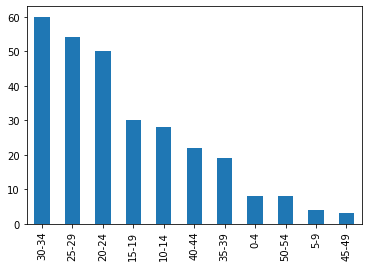

In [20]:
df['tumor-size'].value_counts().plot.bar()

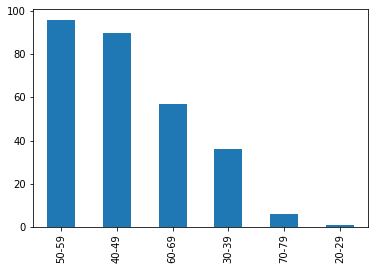

In [21]:
df['age'].value_counts().plot.bar()

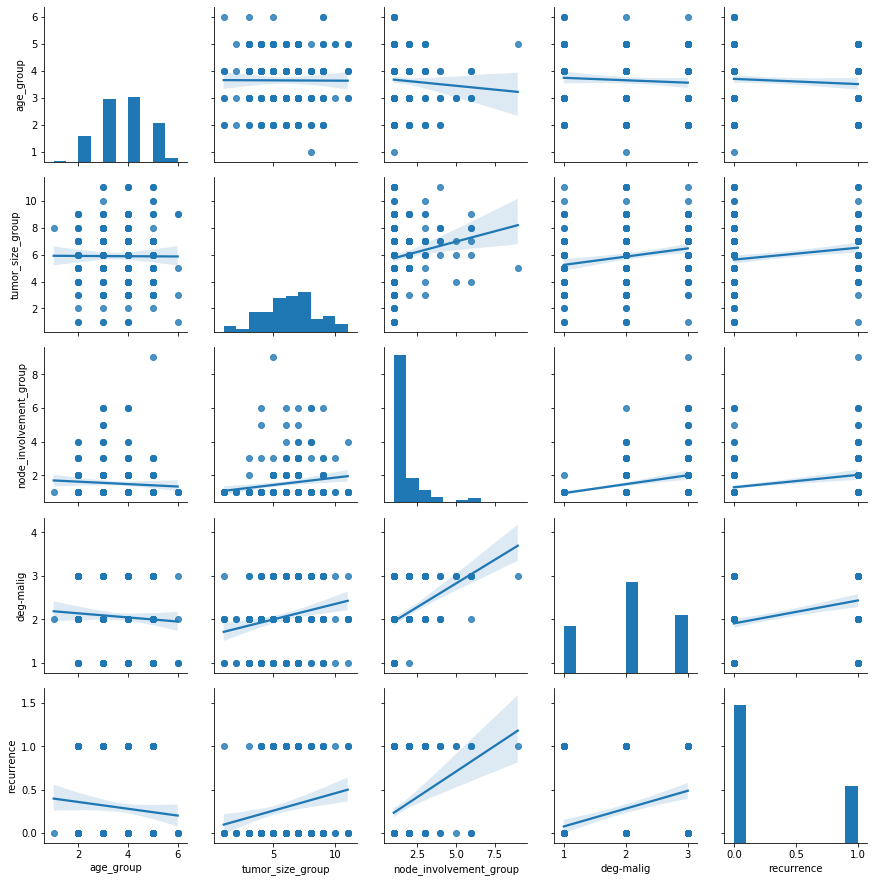

In [22]:
# Pairplot 여러 변수간 산점도 그래프 그리기
import seaborn as sns 
import matplotlib.pyplot as plt

# from pandas.plotting import scatter_matrix
# scatter_matrix(breast[features], c = breast[target],alpha = 0.5,figsize = (10,10))

#sns.pairplot(breast)
g = sns.PairGrid(breast)
g = g.map_diag(plt.hist) # 대각선은 히스토그램
g = g.map_offdiag(sns.regplot)

plt.show()

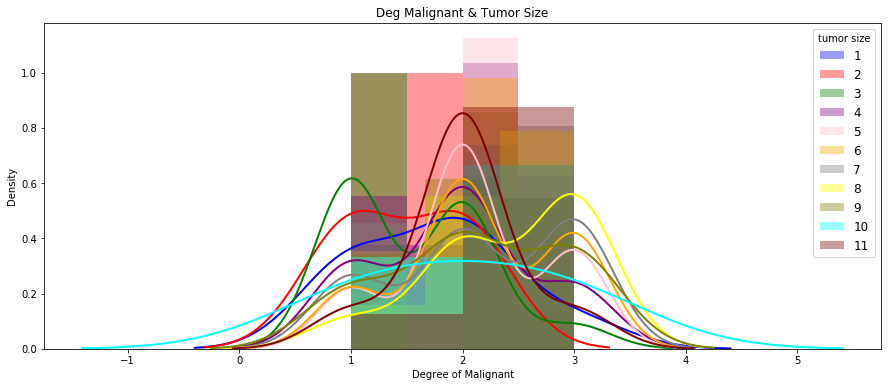

In [71]:
# Density plot
# sns.kdeplot(dataset1, shade = True)
grp_col_dict = {1:'blue',2:'red',3:'green',4:'#800080',5:'#FFC0CB',6:'#FFA500',7:'#808080',8:'#FFFF00',9:'#808000',10:'#00FFFF',11:'#800000'}

plt.figure(figsize = (15,6))
# for loop of species group
for group in grp_col_dict:
    # subset of group
    subset = breast[breast.tumor_size_group == group]
    # histogram and kernel density curve
    sns.distplot(subset['deg-malig'], 
                 # hist = True, # histogram
                 kde = True,  # density curve
                 kde_kws = {'linewidth': 2},
                 color = grp_col_dict[group],
                 label = group)

# setting plot format
plt.title('Deg Malignant & Tumor Size')
plt.xlabel('Degree of Malignant')
plt.ylabel('Density')
plt.legend(prop={'size': 12}, title = 'tumor size')
plt.show()

# Part2: Choose ML Problem

1. 타겟으로 사용할 특성을 선택
2. 풀고자하는 문제가 분류/회귀 문제인지 정하기
3. 타겟의 분포를 분석하고 사용할 평가지표를 선택합니다. 평가지표를 선택한 이유를 설명하세요.
  - 분류: 클래스가 몇 개인지? 클래스 비율이 어떤지(balance or imbalance)
  - 회귀: 타겟 분포가 right-skewed 인지? log-transform을 사용할 것인지?
  - 분류: 다수 클래스(majority class) 비율이 50%~70% 인 경우 정확도(accuracy)만 사용해도 무방합니다. 하지만 범위를 넘어설 경우 정확도만을 사용해서는 모델을 잘못 이해할 수 있습니다. 어떤 평가지표를 사용해야 할까요?
  - 회귀: MAE, RMSE, R^2 등을 사용할 수 있습니다.
4. 데이터를 훈련/검증/테스트 데이터로 나누고 전처리를 수행합니다. 그리고 간단한 모델을 사용해서 학습을 수행합니다.
  - 이상치(outliers)가 있다면 어떻게 처리할 것인지 설명합니다.
  - 무작위로 or 시간에 따라 데이터를 나눌 것인지 설명합니다.
  - 모델 학습 결과를 리포팅 합니다.
  - 정보 누수(leakage)가 있는지 확인해 봅니다


## ? Hypothesis

In [24]:
# two sample t-test deg-malig vs. recurrence
# H0: deg-malig 가 악성일 수록, 재발할 수 있는 가능성이 높다.
from scipy import stats
stats.ttest_ind(breast['deg-malig'],breast['recurrence'])

Ttest_indResult(statistic=34.1423813510989, pvalue=3.500709235277145e-138)

## 2-1 Target & Features Select
- Target: Recurrence 유방암 재발 여부
  - 분류 클래스는 0(no)과 1(yes) 두개 입니다. 
- Features: 유방암 재발 여부를 제외한 그 외의 모든 특성을 선택


In [25]:
# target 과 features 지정
target = 'recurrence'
features = ['age_group', 'menopause', 'tumor_size_group','node_involvement_group',
            'node-caps', 'deg-malig','breast', 'breast-quad', 'irradiat']
#features = ['age_group', 'menopause', 'tumor_size_group','node_involvement_group',
#            'node_caps', 'deg-malig','breast_location', 'irradiat']

In [26]:
# 클래스의 비율이 어떤지 확인해보겠습니다. 
# 타겟은 분류 문제로 정의되며, 유방암 재발 유무에 대한 문제를 해결합니다.
breast[target].value_counts(normalize = True) # class imbalance -> f1 score

0    0.707581
1    0.292419
Name: recurrence, dtype: float64

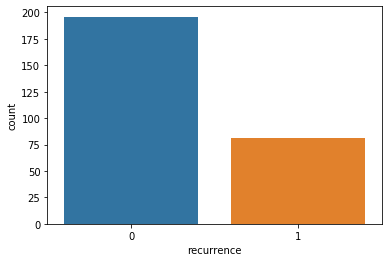

In [27]:
# 그래프를 통하여 타겟의 비율이 어떻게 되는지 확인합니다. 
%matplotlib inline
sns.countplot(x = breast[target])

In [28]:
# 데이터를 훈련/ 테스트 데이터로 나누겠습니다. 
from sklearn.model_selection import train_test_split
train, test = train_test_split(breast, train_size = 0.8, test_size = 0.2, random_state = 2)
train.shape, test.shape

((221, 10), (56, 10))

In [29]:
# 데이터의 양이 적기 때문에 검증데이터셋을 따로 나누지 않고, 교차검증을 통해서 데이터 분석을 진행하겠습니다.
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape

((221, 9), (221,))

## 2-2 간단한 모델링
결정트리로 간단한 모델링을 진행하여 정확도를 확인합니다. 

In [30]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score

pipe_simple = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state = 2, criterion = 'entropy')
)
pipe_simple.fit(X_train, y_train)
print('훈련 정확도: ', pipe_simple.score(X_train,y_train))
y_train_pred_simple = pipe_simple.predict(X_train)
print('훈련 f1 score: ',f1_score(y_train, y_train_pred_simple))

y_test_pred_simple = pipe_simple.predict(X_test)
print('테스트 정확도: ',pipe_simple.score(X_test,y_test))
print('test f1 score: ',f1_score(y_test,y_test_pred_simple))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


훈련 정확도:  0.9773755656108597
훈련 f1 score:  0.9612403100775194
테스트 정확도:  0.6607142857142857
test f1 score:  0.3870967741935484


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [31]:
# 5-fold 교차 검증을 수행
k = 5
scores_simple = cross_val_score(pipe_simple,X_train,y_train,cv = k,scoring = 'f1')
print(f'교차 검증별 정확도 {k} folds:', scores_simple)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


교차 검증별 정확도 5 folds: [0.48275862 0.59259259 0.2962963  0.28571429 0.4       ]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


> DecisionTreeClassifier 결정트리를 사용하였을 때, 과적합이 발생하였습니다. 또한 OneHotEncoder을 사용하였는데, 이후 모델에서는 OrdinalEncoder를 사용하도록 하겠습니다.
> f1 score의 결과값은 0.3 로 매우 낮은 수치가 나왔습니다. 

# Part3: 모델링 Modeling
1. 기준 모델
2. 모델링
3. Tree Graph
4. Feature Importances 
5. Evaluation Metrics 평가지표

## 3-1 Baseline 기준모델

In [33]:
# Baseline 기준모델 
# 0 이 값이 가장 크게 나온 범주변수이기에 기준모델이 됩니다. 
major = y_train.mode()[0]
y_pred_baseline = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print('기준모델의 정확도:',accuracy_score(y_train,y_pred_baseline))
# print('기준모델의 f1 score:',f1_score(y_train,y_pred_baseline))

기준모델의 정확도: 0.6968325791855203


## 3-2 Modeling 모델링

### 3-2-1 모델링 1
- RandomForest

#### 3-2-1-1 RandomForestClassifier

In [34]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

pipe1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 100,random_state = 2, n_jobs = -1) # class_weight='balanced' 값이 더 떨어졌다
)
pipe1.fit(X_train,y_train)
# 훈련 데이터 
print('훈련 정확도: ',pipe1.score(X_train,y_train))
y_train_pred1 = pipe1.predict(X_train)
print('훈련 f1 score: ',f1_score(y_train, y_train_pred1))
# 테스트 데이터
y_test_pred1 = pipe1.predict(X_test)
print('테스트 정확도: ',accuracy_score(y_test,y_test_pred1))
print('테스트 f1 score: ',f1_score(y_test, y_test_pred1))

훈련 정확도:  0.9773755656108597
훈련 f1 score:  0.9618320610687023
테스트 정확도:  0.7142857142857143
테스트 f1 score:  0.4666666666666667


#### 3-2-1-2 교차 검증(Cross-Validation)

In [35]:
# 5-fold 교차 검증을 수행
k = 5
scores = cross_val_score(pipe1,X_train,y_train,cv = k,scoring = 'f1')
print(f'교차 검증별 f1 score {k} folds:', scores)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

교차 검증별 f1 score 5 folds: [0.36363636 0.59259259 0.25       0.64       0.45454545]


In [36]:
# HyperParameter Search
sorted(pipe1.get_params().keys())

['memory',
 'ordinalencoder',
 'ordinalencoder__cols',
 'ordinalencoder__drop_invariant',
 'ordinalencoder__handle_missing',
 'ordinalencoder__handle_unknown',
 'ordinalencoder__mapping',
 'ordinalencoder__return_df',
 'ordinalencoder__verbose',
 'randomforestclassifier',
 'randomforestclassifier__bootstrap',
 'randomforestclassifier__ccp_alpha',
 'randomforestclassifier__class_weight',
 'randomforestclassifier__criterion',
 'randomforestclassifier__max_depth',
 'randomforestclassifier__max_features',
 'randomforestclassifier__max_leaf_nodes',
 'randomforestclassifier__max_samples',
 'randomforestclassifier__min_impurity_decrease',
 'randomforestclassifier__min_impurity_split',
 'randomforestclassifier__min_samples_leaf',
 'randomforestclassifier__min_samples_split',
 'randomforestclassifier__min_weight_fraction_leaf',
 'randomforestclassifier__n_estimators',
 'randomforestclassifier__n_jobs',
 'randomforestclassifier__oob_score',
 'randomforestclassifier__random_state',
 'randomforest

#### 3-2-1-3 HyperParameter Tuning
uesd RandomizedSearchCV 랜덤탐색을 사용하여 하이퍼 파라미터 튜닝을 진행하였습니다. 

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# 하이퍼파라미터 범위 지정
params = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth':randint(0,20),
    'randomforestclassifier__max_features':randint(0,8),
    'randomforestclassifier__min_samples_leaf':randint(1,20),
    'randomforestclassifier__min_samples_split':randint(1,10),
    'randomforestclassifier__n_estimators':randint(50,500)
}

clf = RandomizedSearchCV(pipe1,
                         param_distributions = params,
                         n_iter = 100, # 몇번 반복하여 수행할 것인지
                         cv = 5, # 5번의 교차 검증
                         scoring = 'f1', # f1 점수를 최적화합니다.
                         n_jobs = -1) # 100 * 5 = 500번 진행
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.464662   0.44608187 0.46383964        nan 0.36052632
 0.432493   0.44538887 0.41860829 0.38404688 0.43344538 0.32503268
 0.44348867 0.45026738        nan        nan 0.36052632 0.32532164
 0.41845111 0.40338346 0.47108351 0.20372549 0.35964912        nan
        nan        nan 0.46368953 0.42998217 0.48445785 0.44064579
 0.45026738        nan 0.45907308 0.43704229 0.43641457 0.44205821
 0.4341927         nan        nan 0.43103065 0.48507633 0.45907308
 0.47737374 0.3996313  0.33234262        nan 0.47791878 0.39876161
 0.42146543 0.44634581        nan 0.47269537        nan 0.4341927
 0.45026738        nan 0.45026738        nan        nan 0.45907308
 0.30777778 0.45026738 0.45026738        nan        nan 0.33503268
 0.42998217 0.45591103        nan 0.42117647 0.45737374 0.
 0.38479876 0.44410899        nan 0.44868347        nan        nan

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['menopause',
                                                                   'node-caps',
                                                                   'breast',
                                                                   'breast-quad',
                                                                   'irradiat'],
                                                             mapping=[{'col': 'menopause',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': premeno    1
ge40       2
lt40       3
NaN       -2
dtype: int64},
                                                                      {'col': 'node-caps',
                                                                       'data_type': d

In [38]:
# 최적의 파라미터
print('최적 하이퍼파라미터: ',clf.best_params_)
print('F1 Score: ',clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 4, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__n_estimators': 122, 'simpleimputer__strategy': 'mean'}
F1 Score:  0.5015861331650806


In [39]:
# 각 하이퍼파라미터 조합으로 만들어진 모델들을 순위별로 나열
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,94,40,28,46,42,51,86,20,1,89,84,3,26,41,32,90,59,70,67,85,54,13,82,56,62,30,61,97,75,49,2,7,91,73,12,35,29,33,34,80,...,95,16,5,22,65,44,17,11,60,21,96,92,71,81,14,15,4,83,93,50,76,78,55,57,58,45,63,64,38,79,37,31,25,24,74,23,52,77,68,0
mean_fit_time,0.40389,1.23519,0.294596,1.12059,1.00261,1.00085,0.7555,1.15047,0.355584,0.481941,0.156239,0.428487,0.592404,1.0297,1.10969,0.730631,1.27485,0.176484,0.875136,0.683664,0.46101,0.54997,0.567385,1.14513,0.940213,1.23217,0.865491,0.86058,0.996738,0.636235,0.575503,0.442423,0.405478,1.00804,0.750153,0.317568,0.588394,1.11333,0.751235,0.753554,...,0.554337,0.98902,0.442577,0.582537,1.10316,0.862272,1.28238,1.04598,0.747993,1.06952,0.413813,0.734649,1.13466,0.201846,0.240868,0.23671,0.340811,0.325655,0.441515,0.216465,0.365211,0.349687,0.352079,0.305156,0.366153,0.316941,0.402248,0.149527,0.365506,0.260876,0.15526,0.203756,0.333615,0.269631,0.473858,0.493346,0.201513,0.192628,0.211024,0.33286
std_fit_time,0.0390449,0.0582136,0.0211196,0.03054,0.0330196,0.0405035,0.0141179,0.0438403,0.0272721,0.0500976,0.00113503,0.0208719,0.0320683,0.00792954,0.0410556,0.0208037,0.0429597,0.0227977,0.0393013,0.0439646,0.00929856,0.0390049,0.0205201,0.0417066,0.059172,0.0460858,0.0169429,0.0544415,0.0510718,0.0330995,0.0119948,0.0325236,0.040596,0.032371,0.0341625,0.0038608,0.0302973,0.054744,0.0206761,0.0175574,...,0.0302075,0.0277787,0.00904061,0.0446173,0.0611621,0.0275631,0.0586059,0.0190626,0.00976424,0.0268259,0.0259102,0.0388208,0.0560657,0.0176248,0.0144304,0.0105335,0.0202673,0.0305704,0.0165557,0.0183002,0.0377673,0.0250074,0.0178994,0.0269637,0.0090665,0.0301624,0.0186334,0.0047673,0.0126946,0.0227111,0.0163871,0.0145431,0.0099962,0.0160499,0.0180005,0.00502323,0.00813633,0.0104735,0.0190985,0.00817929
mean_score_time,0.112832,0.201411,0.116461,0.114203,0.11418,0.114497,0.114372,0.173988,0.114358,0.114553,0.116528,0.112527,0.114544,0.131144,0.133617,0.115036,0.21442,0.114231,0.117109,0.112779,0.11374,0.113816,0.113703,0.154932,0.11438,0.195045,0.114549,0.113793,0.113474,0.112492,0.111881,0.114124,0.116391,0.134865,0.113232,0.112968,0.114092,0.1134,0.113373,0.115936,...,0.113686,0.115569,0.114429,0.11476,0.175784,0.113554,0.193193,0.115583,0.113735,0.135869,0.112771,0.113259,0.173703,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
std_score_time,0.00298972,0.0350946,0.00382518,0.0009794,0.00137608,0.00519315,0.000913491,0.0481818,0.00523366,0.00127039,0.00154375,0.00239567,0.000664887,0.0405854,0.040706,0.00368636,0.00252213,0.00168628,0.00636435,0.00102108,0.00128696,0.00241431,0.00281245,0.0514841,0.00242875,0.0401374,0.00239631,0.00136596,0.001229,0.00248639,0.0018136,0.00288653,0.0071827,0.0406559,0.000713082,0.00293644,0.00147514,0.00176905,0.00229697,0.00489129,...,0.00162491,0.00296639,0.00278389,0.00245196,0.0460138,0.00226784,0.0393011,0.00381863,0.00343216,0.0417734,0.000912493,0.00151966,0.0494389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
param_randomforestclassifier__max_depth,8,16,5,16,9,14,16,6,7,16,18,17,6,16,11,19,5,12,4,17,13,15,7,9,2,15,13,12,14,5,6,4,12,15,19,7,14,14,6,15,...,2,1,1,9,5,18,1,17,1,4,13,8,6,13,15,16,13,17,16,10,18,13,12,16,15,15,0,17,10,9,1,2,4,9,7,0,4,0,10,19
param_randomforestclassifier__max_features,4,7,6,5,7,6,5,4,5,6,5,6,4,6,7,7,7,5,6,5,6,5,6,6,7,7,6,3,6,7,1,4,6,2,7,6,3,3,6,4,...,3,5,6,1,1,3,4,2,3,2,1,1,1,0,0,0,6,0,3,6,0,5,0,1,0,0,7,2,0,0,1,0,4,2,2,3,0,2,0,7
param_randomforestclassifier__min_samples_leaf,1,7,1,4,9,5,5,2,1,3,9,2,5,15,14,15,8,6,8,1,18,18,18,17,18,19,19,2,12,16,2,5,15,3,16,13,4,1,19,8,...,14,7,10,6,7,17,10,14,7,17,12,12,19,15,10,13,18,2,18,2,9,6,11,5,15,17,7,10,12,8,17,13,12,7,14,17,17,11,7,9
param_randomforestclassifier__min_samples_split,7,7,8,2,9,7,4,9,2,8,9,8,3,2,4,3,3,8,9,9,7,7,9,8,9,5,9,2,8,5,2,2,3,5,6,7,9,2,3,5,...,3,5,2,7,8,5,9,2,9,7,8,2,3,4,7,6,1,6,1,1,5,1,5,1,3,9,3,1,7,3,1,2,1,1,1,6,6,5,3,1
param_randomforestclassifier__n_estimators,122,477,97,415,385,384,270,457,114,174,52,141,225,398,421,266,494,52,341,248,165,18

#### 3-2-1-4 최적의 모델

In [40]:
# 성능이 가장 좋은 모델을 불러옵니다.
model = clf.best_estimator_
model.fit(X_train,y_train)
# model.transform(X_test)

y_train_pred = model.predict(X_train)
print('훈련 정확도:',model.score(X_train,y_train))
print('훈련 f1 score: ',f1_score(y_train,y_train_pred))

y_pred = model.predict(X_test) # 테스트 데이터의 예측값
print('테스트 정확도: ',accuracy_score(y_test,y_pred))
print('테스트 f1 score: ',f1_score(y_test,y_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도: 0.8868778280542986
훈련 f1 score:  0.7826086956521741
테스트 정확도:  0.7142857142857143
테스트 f1 score:  0.42857142857142855


In [41]:
model

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['menopause', 'node-caps', 'breast',
                                      'breast-quad', 'irradiat'],
                                mapping=[{'col': 'menopause',
                                          'data_type': dtype('O'),
                                          'mapping': premeno    1
ge40       2
lt40       3
NaN       -2
dtype: int64},
                                         {'col': 'node-caps',
                                          'data_type': dtype('O'),
                                          'mapping': yes    1
no     2
NaN   -2
dtype: int64},
                                         {'col': 'breast',
                                          'data_type': dtype('O'),
                                          'mapping': left     1
right    2
Na...
                                         {'col': 'breast-quad',
                                          'data_type': dtype('O'),
              

#### 3-2-1-5 Tree Graph

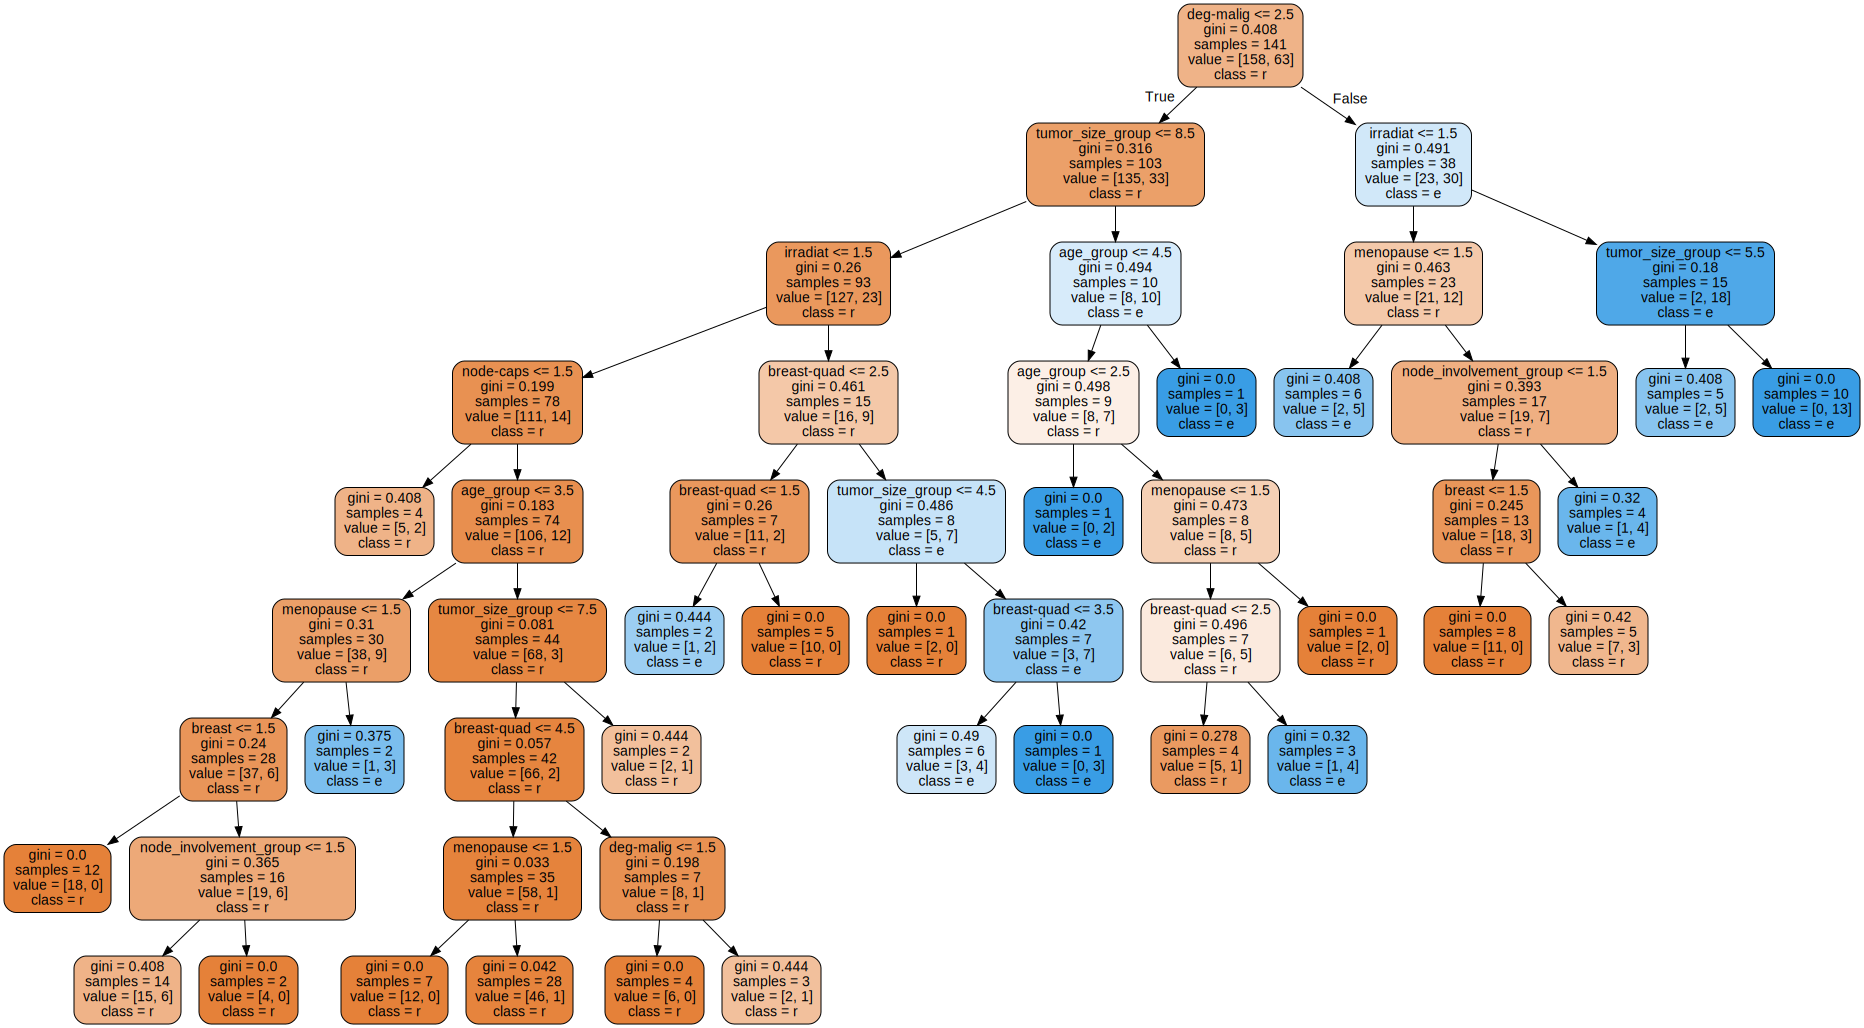

In [68]:
import graphviz
from sklearn.tree import export_graphviz
## preprocessing = model.named_steps['ordinalencoder']['simpleimputer']
# randomforest 예측 모델 불러오기
estimator = model.named_steps['randomforestclassifier'][1] # 여러개의 트리중 하나의 트리만 그립니다. 
feature_names = X_train.columns.tolist() # 특성 이름들을 리스트로 불러오기

trees_graph = export_graphviz(estimator, # model
                feature_names = feature_names, # 변수명
                class_names = target, # 종속변수
                max_depth = 12, # 표현하고 싶은 최대 depth
                precision = 3,  # 소수점 표기 자릿수
                filled = True, # class 별 color 채우기
                rounded = True) # 박스의 모양을 둥글게 

dot = graphviz.Source(trees_graph) # save tree graph's source
dot.render(filename = 'tree.png') # save as .png file
display(graphviz.Source(trees_graph))

### 3-2-2 모델링 2

- xgboost 그래디언트 부스팅


In [43]:
# 그래디언트 부스팅으로 학습
from xgboost import XGBClassifier

pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200,
                  random_state=2,
                  n_jobs=-1, 
                  max_depth=7, 
                  learning_rate=0.2
                  )
)

pipe2.fit(X_train, y_train);
# 정확도 및 f1 score 
y_train_pred2 = pipe2.predict(X_train)
print('훈련 정확도:',pipe2.score(X_train,y_train))
print('훈련 f1 score: ', f1_score(y_train, y_train_pred2))

y_test_pred2 = pipe2.predict(X_test)
print('테스트 정확도: ', accuracy_score(y_test, y_test_pred2))
print('테스트 f1 score: ', f1_score(y_test, y_test_pred2))


훈련 정확도: 0.9773755656108597
훈련 f1 score:  0.9612403100775194
테스트 정확도:  0.6785714285714286
테스트 f1 score:  0.47058823529411764


In [44]:
# 재학습
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
X_train_processed = processor.fit_transform(X_train) # 학습데이터
X_test_processed = processor.transform(X_test) # 검증데이터

# ratio = 클래스의 비율 : 0->0.702797, 1->0.297203
ratio = 0.297203/0.702797

model2 = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=3,        # default=3
    learning_rate=0.2,
    scale_pos_weight = ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_processed, y_train), 
            (X_test_processed, y_test)]

model2.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.230769	validation_1-error:0.267857
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.235294	validation_1-error:0.25
[2]	validation_0-error:0.226244	validation_1-error:0.25
[3]	validation_0-error:0.226244	validation_1-error:0.25
[4]	validation_0-error:0.230769	validation_1-error:0.25
[5]	validation_0-error:0.226244	validation_1-error:0.232143
[6]	validation_0-error:0.226244	validation_1-error:0.232143
[7]	validation_0-error:0.226244	validation_1-error:0.232143
[8]	validation_0-error:0.226244	validation_1-error:0.232143
[9]	validation_0-error:0.226244	validation_1-error:0.232143
[10]	validation_0-error:0.230769	validation_1-error:0.232143
[11]	validation_0-error:0.226244	validation_1-error:0.232143
[12]	validation_0-error:0.230769	validation_1-error:0.232143
[13]	validation_0-error:0.226244	validation_1-error:0.232143
[14]	valida

XGBClassifier(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
              scale_pos_weight=0.4228859827233184)

In [45]:
# model2 의 평가지표
y_train_pred_model2 = model2.predict(X_train_processed)
print('훈련 정확도', model2.score(X_train_processed, y_train))
print('훈련 f1 score',f1_score(y_train, y_train_pred_model2))

y_test_pred_model2 = model2.predict(X_test_processed)
print('테스트 정확도', model2.score(X_test_processed, y_test))
print('테스트 f1 score',f1_score(y_test, y_test_pred_model2))

훈련 정확도 0.7692307692307693
훈련 f1 score 0.38554216867469876
테스트 정확도 0.7857142857142857
테스트 f1 score 0.4


### 3-2-3 Best Model

In [46]:
from sklearn.metrics import classification_report
print('RandomForest: \n',classification_report(y_test,y_pred)) # model
print('XGBoost: \n',classification_report(y_test, y_test_pred2)) # pipe2
print('그래디언트 부스팅: \n',classification_report(y_test, y_test_pred_model2)) # model2

RandomForest: 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.43      0.43      0.43        14

    accuracy                           0.71        56
   macro avg       0.62      0.62      0.62        56
weighted avg       0.71      0.71      0.71        56

XGBoost: 
               precision    recall  f1-score   support

           0       0.83      0.71      0.77        42
           1       0.40      0.57      0.47        14

    accuracy                           0.68        56
   macro avg       0.62      0.64      0.62        56
weighted avg       0.72      0.68      0.69        56

그래디언트 부스팅: 
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        42
           1       0.67      0.29      0.40        14

    accuracy                           0.79        56
   macro avg       0.73      0.62      0.63        56
weighted avg       0.77      0.79 

> 여러 모델들 중, RandomForestClassifier 를 사용하여 최적의 하이퍼파라미터를 찾은 모델이 가장 성능이 좋다고 판단됩니다. 
그 이유로는 
1. 기준모델의 정확도는 0.702 로 테스트의 정확도가 이 점수를 넘어야 합니다. 
2. f1-score 가 너무 낮거나 차이가 나지 않는 것을 고르겠습니다. 


## 3-4 Feature Importance 특성 중요도
RandomForestClassifieer의 특성 중요도

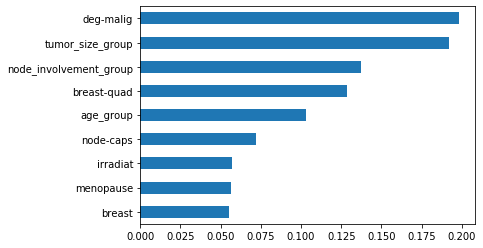

In [47]:
rf_ord = model.named_steps['randomforestclassifier']
#xgb = model2
feature_names = X_train.columns.tolist() # 특성 이름들을 리스트로 불러오기
importances_ord = pd.Series(rf_ord.feature_importances_, feature_names)
#importances_ord = pd.Series(xgb.feature_importances_, feature_names)

importances_ord.sort_values().plot.barh();

> 위의 특성중요도를 통해서 유방암의 조직학적 등급 분류에 따라 재발 여부에 큰 영향을 끼치고 있는 것을 알 수 있습니다. 
그 다음으로는 종양의 크기와 노드의 개수에 따라 재발 여부에 재발 여부에 큰 영향을 끼치고 있는 것을 알 수 있습니다. 

## 3-5 Evaluation Metrics 평가지표

### 3-5-1 Confusion Matrix

<function matplotlib.pyplot.show>

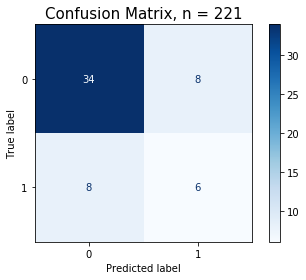

In [48]:

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model, X_test, y_test, 
                            cmap = plt.cm.Blues,ax = ax);
plt.title(f'Confusion Matrix, n = {len(y_train)}',fontsize = 15)
plt.show

In [49]:
cm = pcm.confusion_matrix
cm

array([[34,  8],
       [ 8,  6]])

In [50]:
import numpy as np
# TP
# 예측: functional, 실제: functional
TP = cm[1][1]
# 정확하게 맞춘 예측은 TP+TN
correct_prediction = np.diag(cm).sum()
# 총 예측한 수
total_prediction = cm.sum()
# 분류 정확도(classification accuracy)
classification_accuracy = correct_prediction/total_prediction
print('분류 정확도: ',classification_accuracy)

분류 정확도:  0.7142857142857143


### 3-5-2 정밀도와 재현율, 그 외 평가지표

In [51]:
# 정밀도, 재현율, 그 외 지표
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.43      0.43      0.43        14

    accuracy                           0.71        56
   macro avg       0.62      0.62      0.62        56
weighted avg       0.71      0.71      0.71        56



In [52]:
# 정밀도, 재현율, 임계값, 예측확률간의 관계
from ipywidgets import interact, fixed
import seaborn as sns

y_pred_proba = model.predict_proba(X_test)[:,1] # 테스트데이터 

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))
    
interact(explore_threshold, 
    y_true=fixed(y_test), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [53]:
# 실제 타겟 값과 예측 확률을 데이터 프레임으로 만들어 확인 합니다.
pred_proba = pd.DataFrame({
    'y_test': y_test,
    'pred_proba': y_pred_proba})
pred_proba

,y_test,pred_proba
161,0,0.463303
7,0,0.145674
105,1,0.464782
13,0,0.155018
118,0,0.235881
95,0,0.544403
99,1,0.235504
70,1,0.687763
279,0,0.293023
154,0,0.013612


### 3-5-3 ROC, AUC


In [54]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.859327
1,0.023810,0.000000,0.859327
2,0.023810,0.142857,0.810467
3,0.071429,0.142857,0.748549
4,0.071429,0.285714,0.687763
5,0.166667,0.285714,0.544403
6,0.166667,0.428571,0.527311
7,0.214286,0.428571,0.481703
8,0.214286,0.500000,0.464782
9,0.238095,0.500000,0.463303


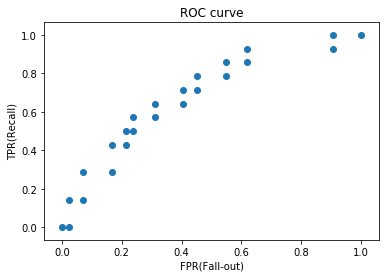

In [55]:
# ROC Curve 그래프
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 12 , threshold: 0.40934892345386975


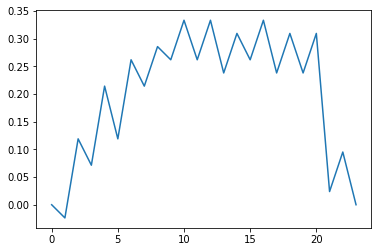

In [56]:
# 최적의 Threshold 임계값 찾기
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)
plt.plot(tpr - fpr);

In [57]:
# 최적의 임계값일 때, 평가지표의 값
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_test, y_pred_optimal))
# f1-score 0-0.74, 1-0.56

              precision    recall  f1-score   support

           0       0.85      0.69      0.76        42
           1       0.41      0.64      0.50        14

    accuracy                           0.68        56
   macro avg       0.63      0.67      0.63        56
weighted avg       0.74      0.68      0.70        56



In [58]:
# AUC 점수
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score
# 0.6786226685796269

0.6989795918367346

# Part4: Interpreting ML Model
## Visualization 시각화
1. Permutation Importances
2. Partial Dependence Plot
3. ~Shapley Values~


## 4-1 Permutation Importances

In [59]:
# 특성별 score 확인
import eli5
eli5.show_weights(
    rf_ord, #xgb
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names = feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1983 ± 0.1857,deg-malig
0.1920 ± 0.1485,tumor_size_group
0.1372 ± 0.2006,node_involvement_group
0.1283 ± 0.1249,breast-quad
0.1034 ± 0.0987,age_group
0.0720 ± 0.1674,node-caps
0.0574 ± 0.0971,irradiat
0.0565 ± 0.1001,menopause
0.0550 ± 0.0950,breast


## 4-2 Partial Dependence Plot(PDP)

### 4-2-1 Partial Dependence Plot, 1 feature isolation


In [60]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
# plt.rcParams['figure.dpi'] = 144

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f3f072990>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f3f09fdd0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


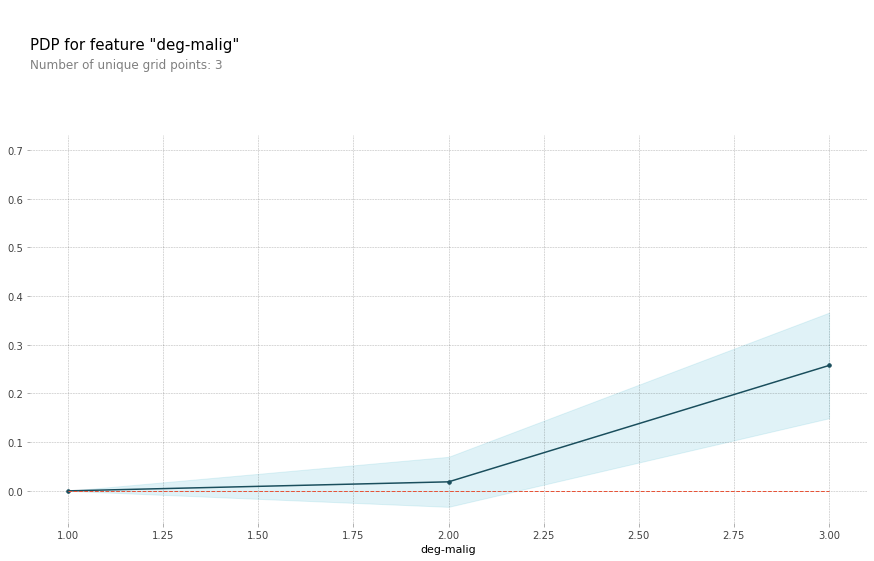

In [61]:
# 특성 성능이 가장 좋은 종양 크기 특성을 사용하여 PDP를 그려보겠습니다.
from pdpbox.pdp import pdp_isolate, pdp_plot
feature1 = 'deg-malig'
# 암의 조직학적 종류에 대한 특성의 PDP
isolated1 = pdp_isolate(
    model = model,
    dataset = X_test,
    model_features = feature_names,
    feature = feature1,
    #grid_type = 'percentile',
    num_grid_points = 10
)
pdp_plot(isolated1, feature_name = feature1)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8ef99fd4d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f3f113ed0>})

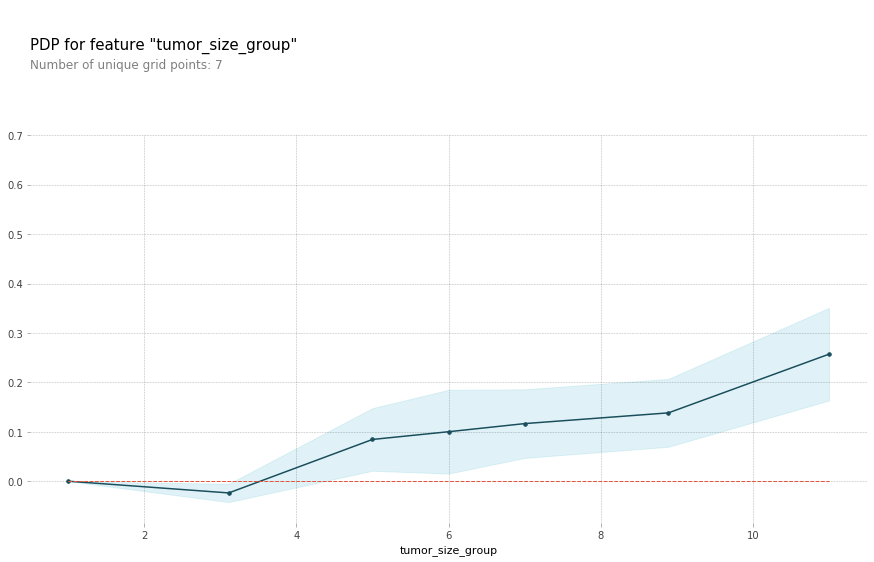

In [62]:

feature2 = 'tumor_size_group'

# 종양 크기에 대한 특성의 PDP
isolated2 = pdp_isolate(
    model = model,
    dataset = X_test,
    model_features = feature_names,
    feature = feature2,
#    grid_type = 'percentile',
    num_grid_points = 10
)
pdp_plot(isolated2, feature_name = feature2)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f403f1c90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f40535490>})

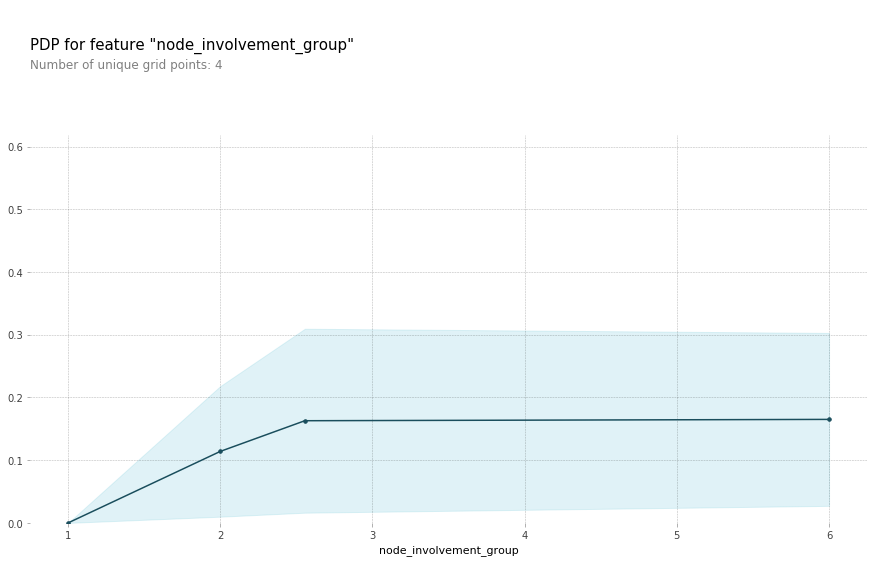

In [75]:
feature3 = 'node_involvement_group'
# node_involvement_group의 위치에 대한 특성의 PDP
isolated3 = pdp_isolate(
    model = model,
    dataset = X_train,
    model_features = feature_names,
    feature = feature3
    #grid_type = 'percentile',
    #num_grid_points = 10
)
pdp_plot(isolated3, feature_name = feature3)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f4c8c6210>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f4c972450>})

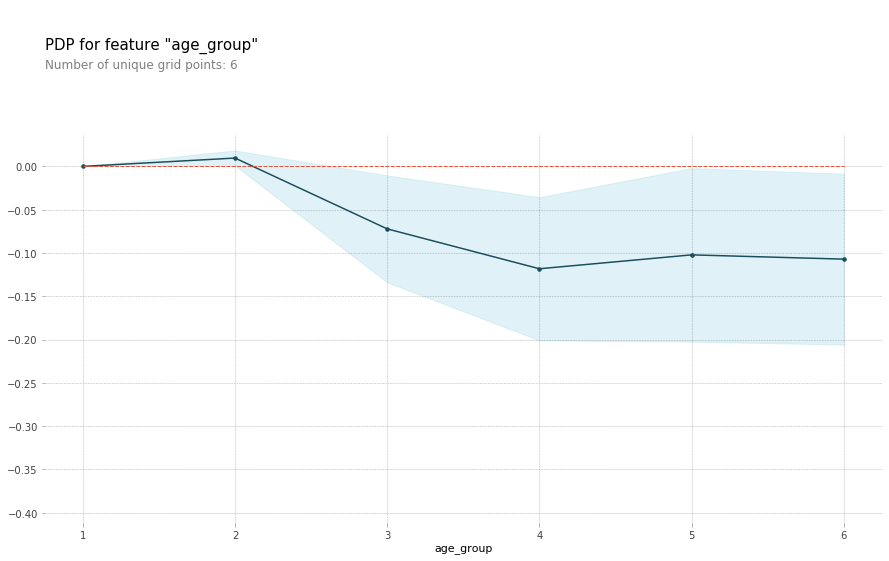

In [64]:
feature4 = 'age_group'
# node_involvement_group의 위치에 대한 특성의 PDP
isolated4 = pdp_isolate(
    model = model,
    dataset = X_train,
    model_features = feature_names,
    feature = feature4,
    grid_type = 'percentile',
    num_grid_points = 10
)
pdp_plot(isolated4, feature_name = feature4)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f4c814cd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8f4c8b2f50>})

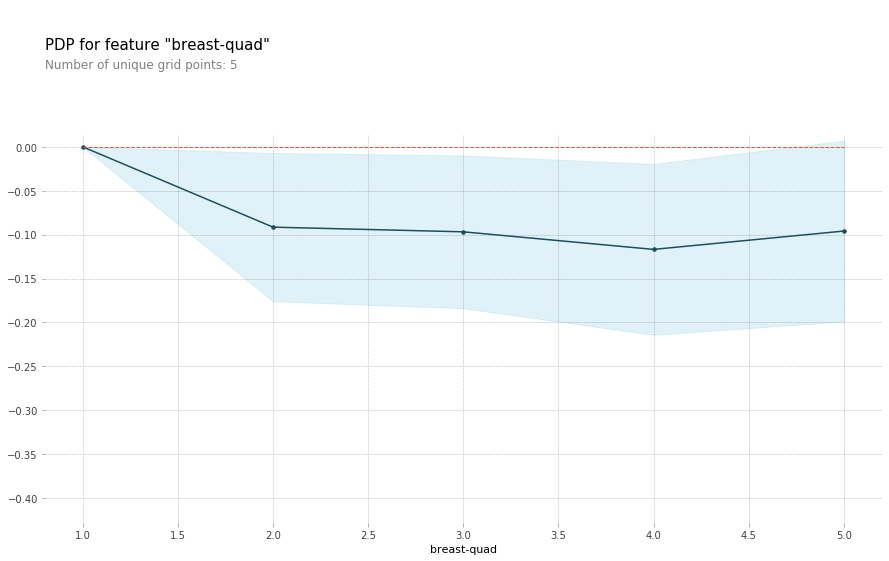

In [65]:
### 데이터가 numeric type 이 아닌 것
feature5 = 'breast-quad'
# 유방암 종양의 위치에 대한 특성의 PDP
# model.named_steps['ordinalencoder'].category_mapping[3]
# 'mapping': left_low     1, left_up      2, right_low    3, right_up     4, central      5
encoder = model.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X_train)

isolated5 = pdp_isolate(
    model = rf_ord,
    dataset = X_encoded,
    model_features = feature_names,
    feature = feature5,
    grid_type = 'percentile',
    num_grid_points = 10
)
pdp_plot(isolated5, feature_name = feature5)

### 4-2-2 Partial Dependence Plot, 2 features interaction

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


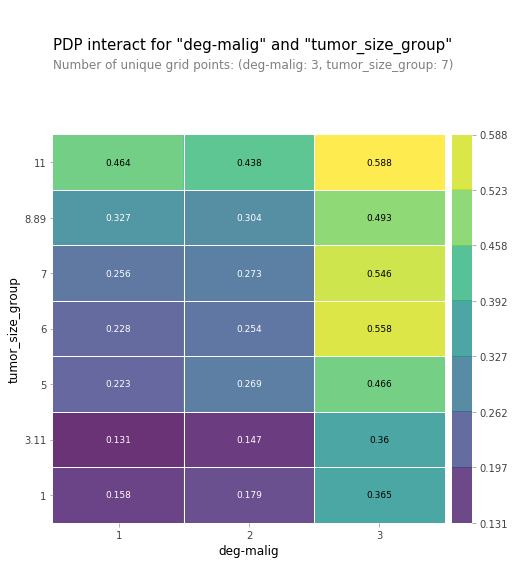

In [66]:
# 두 특성간의 상호작용
from pdpbox.pdp import pdp_interact,pdp_interact_plot
feature6 = ['deg-malig','tumor_size_group']
interaction = pdp_interact(
    model = model,
    dataset = X_test,
    model_features = feature_names,
    features = feature6
)
pdp_interact_plot(interaction, plot_type = 'grid',feature_names = feature6);

2021.07.02 Fin.